In [ ]:
#!/usr/bin/env python
# -*- encoding: utf-8 -*-
'''
@文件        :10.TouValues.ipynb
@说明        :
@时间        :2023/03/05 08:46:44
@作者        :Wu Baosheng
@版本        :1.0
this script is used to calculate the tou specific values for different clusters
'''

In [2]:
import os,re,sys
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
import numpy as np
import tspex
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Arial"

In [7]:
adata = sc.read_h5ad("H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/sevenSpecies.integrate.h5ad")

In [8]:
def cluculateAverage(adata,cluster='leiden'):
    adata.obs[cluster]=adata.obs[cluster].astype('category')
    adata.X=adata.layers['CPM']
    df = pd.DataFrame(columns=adata.var_names, index=adata.obs[cluster].cat.categories)
    for clust in adata.obs[cluster].cat.categories:
        df.loc[clust] = adata[adata.obs[cluster].isin([clust]),:].X.mean(axis=0)
    df=df.astype(float)
    df=np.log1p(df)
    return df

def transSpeciesSadata(adata,species,cluster='leiden',min_values=10):
    adata2=adata[adata.obs['species']==species]
    if species=='lamprey':
        adata2=adata2[:,adata2.var_names.str.startswith('lm')]
    else:
        sp = species[:2]
        adata2=adata2[:,adata2.var_names.str.startswith(sp)]
    df1=adata2.obs[cluster].value_counts()
    target_group = df1[df1.values>min_values].index.to_list()
    adata2 = adata2[adata2.obs[cluster].isin(target_group)]
    sc.tl.rank_genes_groups(adata2, cluster, method='wilcoxon')
    return adata2

In [9]:
lancelet=transSpeciesSadata(adata,'lancelet')
lamprey=transSpeciesSadata(adata,'lamprey')
dogshark=transSpeciesSadata(adata,'dogshark')
bichir=transSpeciesSadata(adata,'bichir')
lungfish=transSpeciesSadata(adata,'lungfish')
frog=transSpeciesSadata(adata,'frog')
human=transSpeciesSadata(adata,'human')

c:\Users\wubaosheng\AppData\Local\Programs\Python\Python39\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
c:\Users\wubaosheng\AppData\Local\Programs\Python\Python39\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
c:\Users\wubaosheng\AppData\Local\Programs\Python\Python39\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
c:\Users\wubaosheng\AppData\Local\Programs\Python\Python39\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
c:\Users\wubaosheng\AppD

In [10]:
bichir2=sc.read('H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/01.h5ad_counts/bichir_counts.h5ad')

In [11]:
bichir2.obs['leiden_samap']=bichir.obs['leiden']

In [14]:
dogshark2=sc.read('H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/01.h5ad_counts/dogshark_counts.h5ad')

In [15]:
dogshark2.obs['leiden_samap']=dogshark.obs['leiden']

In [16]:
frog2=sc.read('H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/01.h5ad_counts/frog_counts.h5ad')
frog2.obs['leiden_samap']=frog.obs['leiden']

In [17]:
human2=sc.read('H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/01.h5ad_counts/human_counts.h5ad')
human2.obs['leiden_samap']=human.obs['leiden']

In [18]:
lamprey2=sc.read('H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/01.h5ad_counts/lamprey_counts.h5ad')
lamprey2.obs['leiden_samap']=lamprey.obs['leiden']

In [19]:
lancelet2=sc.read('H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/01.h5ad_counts/lancelet_counts.h5ad')
lancelet2.obs['leiden_samap']=lancelet.obs['leiden']

In [20]:
lungfish2=sc.read('H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/01.h5ad_counts/lungfish_counts.h5ad')
lungfish2.obs['leiden_samap']=lungfish.obs['leiden']

In [21]:
df_lancelet=cluculateAverage(lancelet2,cluster='leiden_samap')
df_lamprey=cluculateAverage(lamprey2,cluster='leiden_samap')
df_dogshark=cluculateAverage(dogshark2,cluster='leiden_samap')
df_bichir=cluculateAverage(bichir2,cluster='leiden_samap')
df_lungfish=cluculateAverage(lungfish2,cluster='leiden_samap')
df_frog=cluculateAverage(frog2,cluster='leiden_samap')
df_human=cluculateAverage(human2,cluster='leiden_samap')

In [22]:
info_dir = {'lancelet':df_lancelet,'lamprey':df_lamprey,'dogshark':df_dogshark,'bichir':df_bichir,'lungfish':df_lungfish,'frog':df_frog,'human':df_human}
def specifExpressionForTissues(df_dir,method='spm',cluster='7'):
    valus_dir = {}
    for x in df_dir.keys():
        tso = tspex.TissueSpecificity(df_dir[x].T.astype(float), 'spm', log=False, threshold=0)
        data=tso.tissue_specificity.melt()
        valus_dir[x]=data[data['variable']==cluster]['value'].to_list()
    df1 = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in valus_dir.items()]))
    return df1

<AxesSubplot:xlabel='variable', ylabel='value'>

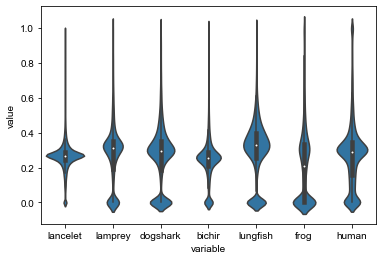

In [23]:
df_endo = specifExpressionForTissues(df_dir=info_dir)
sns.violinplot(x="variable", y="value",  scale="count", color='C0',data=df_endo.melt())

meta NOT subset; don't know how to subset; dropped


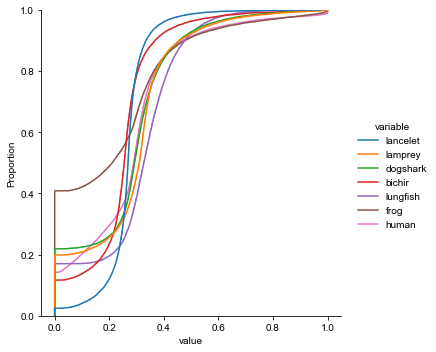

In [354]:
# sns.displot(df_endo.melt(), x="value", hue="variable", kind="kde", fill=True)
sns.displot(df_endo.melt(), x="value", hue="variable", kind="ecdf")  ###hist, kde, ecdf
plt.savefig('H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/03.endothelial/endothelial_cell_spm_marker.pdf')

In [24]:
df_endo['human'].dropna()

0        0.1804
1        0.0911
2        0.1263
3        0.3578
4        0.2635
          ...  
22420    0.1482
22421    0.3333
22422    0.2782
22423    0.3761
22424    0.3181
Name: human, Length: 22425, dtype: float64

In [25]:
df_counts=pd.DataFrame(columns=['species','counts'])
for i in df_endo.columns:
    tmp = [x for x in df_endo[i] if x>=0.5]
    df_counts.loc[i]=[i,len(tmp)]
    print(f'{i}:{len(tmp)}')

lancelet:379
lamprey:1117
dogshark:1436
bichir:659
lungfish:1466
frog:1474
human:1942


In [343]:
gene_sum=[27957,18961,22365,20974,19458,26445,22425]
df_counts['gene_sum']=gene_sum
df_counts['ratio']=df_counts['counts']/df_counts['gene_sum']

In [344]:
df_counts

species counts  gene_sum      ratio
lancelet  lancelet    379     27957  0.0135565
lamprey    lamprey   1117     18961  0.0589104
dogshark  dogshark   1436     22365  0.0642075
bichir      bichir    659     20974  0.0314199
lungfish  lungfish   1466     19458  0.0753418
frog          frog   1474     26445  0.0557383
human        human   1942     22425  0.0865998

In [347]:
# fig1 = px.box(df_counts,x='species',y='counts')
fig1=px.bar(df_counts,x='species',y='ratio',text='ratio')
# fig1 = px.violin(df_endo,box=True)  ###,points='all'
# fig1.update_traces(marker={'size': 2})     #### set the size of point  
fig1.show()
pio.write_image(fig1,'./endothelial_cell_spm_0.5_marker.pdf', format='pdf')

In [348]:
os.getcwd()

'h:\\002.singcell\\01.liver\\10.mutileSpecies\\05.SAMap'

In [16]:
##### calculate the tissue specificity for each species
valus_dir2 = {}
for key in info_dir.keys():
    tso = tspex.TissueSpecificity(info_dir[key].T.astype(float), 'tau', log=False, threshold=0)
    valus_dir2[key]=tso.tissue_specificity.values
df2 = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in valus_dir2.items()]))

In [24]:
# fig = px.box(df2,)
fig = px.violin(df2,box=True)  ###,points='all'
fig.update_traces(marker={'size': 2})     #### set the size of point  
fig.show()
# pio.write_image(fig,'./species-tou-expression.pdf', format='pdf')

In [17]:
df2

lancelet  lamprey  dogshark  bichir  lungfish    frog   human
0        0.1443   0.3708    0.4550  0.4032    0.8584  0.9152  0.4346
1        0.5944   0.5166    0.2731  0.3412    0.9144  0.6689  0.6228
2        0.2699   0.4853    0.6653  0.6256    0.4849  0.6794  0.5420
3        0.4875   0.6235    0.8396  0.8310    0.5133  0.6725  0.3640
4        0.5517   0.4522    0.3997  0.8137    0.6108  0.7304  0.6141
...         ...      ...       ...     ...       ...     ...     ...
27952    0.2229      NaN       NaN     NaN       NaN     NaN     NaN
27953    0.2477      NaN       NaN     NaN       NaN     NaN     NaN
27954    0.0490      NaN       NaN     NaN       NaN     NaN     NaN
27955    0.1023      NaN       NaN     NaN       NaN     NaN     NaN
27956    0.0886      NaN       NaN     NaN       NaN     NaN     NaN

[27957 rows x 7 columns]

In [ ]:
import numpy as np
from scipy.stats import ttest_ind

# Generate two sets of random data
group1 = df2['lamprey'].dropna()
group2 = df2['lungfish'].dropna()
# Perform a two-sample t-test
t_stat, p_val = ttest_ind(group1, group2)
# Print the results
print("t-statistic:", t_stat)
print("p-value:", p_val)

In [35]:
tmp=df2.columns.to_list()
p_list = []
count=0
for col in df2.columns:
    t = []
    count+=1
    print(count)
    for col2 in tmp:
        group1 = df2[col].dropna()
        group2 = df2[col2].dropna()
        t_stat, p_val = ttest_ind(group1, group2)
        t.append(p_val)
    p_list.append(t)

1
2
3
4
5
6
7


In [38]:
df3 = pd.DataFrame(p_list,columns=tmp,index=tmp)


In [44]:
df3.to_csv('H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/P_values_for_tissue_specificity.txt',sep='\t',header=True,index=True)

In [40]:
tmp2=df_endo.columns.to_list()
p_list2 = []
count=0
for col in df_endo.columns:
    t = []
    count+=1
    print(count)
    for col2 in tmp2:
        group1 = df_endo[col][df_endo[col]>=0.5].dropna()
        group2 = df_endo[col2][df_endo[col2]>=0.5].dropna()
        t_stat, p_val = ttest_ind(group1, group2)
        t.append(p_val)
    p_list2.append(t)

1
2
3
4
5
6
7


In [46]:
[len(df_endo[col][df_endo[col]>=0.5]) for col in df_endo.columns]

[379, 1117, 1436, 659, 1466, 1474, 1942]

In [48]:
### t-test
import pandas as pd
from scipy.stats import ttest_1samp
ttest_1samp([1117, 1436, 659, 1466, 1474, 1942], 379)

Ttest_1sampResult(statistic=5.543744212902489, pvalue=0.0026222157297269484)

In [41]:
df4=pd.DataFrame(p_list2,columns=tmp2,index=tmp2)

<AxesSubplot:>

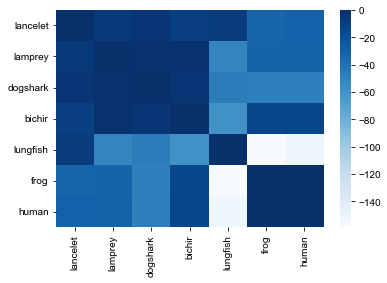

In [42]:
sns.heatmap(np.log10(df4),cmap='Blues')

In [43]:
df4

lancelet       lamprey      dogshark        bichir  \
lancelet  1.000000e+00  7.356356e-07  4.763034e-05  3.427185e-10   
lamprey   7.356356e-07  1.000000e+00  7.047357e-02  2.575641e-02   
dogshark  4.763034e-05  7.047357e-02  1.000000e+00  7.217300e-05   
bichir    3.427185e-10  2.575641e-02  7.217300e-05  1.000000e+00   
lungfish  1.979011e-08  3.322204e-52  9.203195e-47  6.382718e-60   
frog      3.286094e-33  4.728301e-32  4.328026e-49  1.244473e-14   
human     1.187736e-30  1.614483e-31  8.501044e-49  6.480381e-14   

               lungfish           frog          human  
lancelet   1.979011e-08   3.286094e-33   1.187736e-30  
lamprey    3.322204e-52   4.728301e-32   1.614483e-31  
dogshark   9.203195e-47   4.328026e-49   8.501044e-49  
bichir     6.382718e-60   1.244473e-14   6.480381e-14  
lungfish   1.000000e+00  8.647402e-160  1.620486e-153  
frog      8.647402e-160   1.000000e+00   9.029483e-01  
human     1.620486e-153   9.029483e-01   1.000000e+00